# Dataset

In [1]:
from modules.dataset import SignalDataset
from modules.preprocess import AutoCorrPeak, XCorrPeak
from modules.augmentation import AWGN, MP
from modules.generators import SinSweepGen,LFMSweepGen, BPSKGen, SinSweepMultiToneGen, WeirdGen

### Transform

In [2]:
from torch import nn
from torch.random import manual_seed
manual_seed(513)

peak_width_factor=50

class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.awgn = AWGN()
        self.mp = MP()
        self.xcorr_peak_extractor = XCorrPeak(peak_width_factor=peak_width_factor)
        
    def forward(self, x):
        y = self.awgn(x)
        y = self.mp(y)
        y = self.xcorr_peak_extractor(y, x)
        return y
    
class TransformTest(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.awgn = AWGN()
        self.mp = MP()
        self.xcorr_peak_extractor = XCorrPeak(peak_width_factor=peak_width_factor)
        
    def forward(self, x):
        y = self.awgn(x)
        y = self.mp(y)
        y = self.xcorr_peak_extractor(y, x)
        return y
    
# gen_objs_train = [SinSweepGen(), SinSweepMultiToneGen(), LFMSweepGen()]
# gen_objs_train = [SinSweepGen(), SinSweepMultiToneGen()]
# gen_objs_train = [SinSweepGen(), BPSKGen(), LFMSweepGen()]
# gen_objs_train = [BPSKGen(), SinSweepGen(), LFMSweepGen(), SinSweepMultiToneGen(), WeirdGen()]
gen_objs_train = [BPSKGen(), SinSweepGen(), LFMSweepGen(), SinSweepMultiToneGen()]

# gen_objs_test = [BPSKGen(), SinSweepGen(), LFMSweepGen(), SinSweepMultiToneGen()]
gen_objs_test = [SinSweepGen(), BPSKGen(), LFMSweepGen()]
# gen_objs_test = [ SinSweepGen(), SinSweepMultiToneGen()]
# gen_objs_test = [BPSKGen(), SinSweepGen(), LFMSweepGen(), SinSweepMultiToneGen()]
# gen_objs_test = [BPSKGen(), SinSweepGen(), LFMSweepGen(), SinSweepMultiToneGen(), WeirdGen()]

# gen_objs_train = [WeirdGen()]

In [3]:
train_ds = SignalDataset(gen_objs_train, transform=Transform())
test_ds = SignalDataset(gen_objs_test, transform=TransformTest())

In [4]:
# %%timeit
# (peak1abs, _), (peak2abs, _), label = next(train_ds)

### demonstrate data

In [5]:
%matplotlib inline
%matplotlib widget

### Plot Peaks

In [6]:
# %matplotlib widget
# import matplotlib.pyplot as plt
# plt.figure()

# (peak1abs, _), (peak2abs, _), label = next(train_ds)
# plt.plot(peak1abs)
# plt.title(peak1abs.shape)
# train_ds.gen_objs[label]

### Plot Signal

In [7]:
# %matplotlib widget
# import numpy as np
# from scipy.fft import fftshift
# from scipy.signal import spectrogram

# gen_objs_train = [BPSKGen(), SinSweepGen(), LFMSweepGen(), SinSweepMultiToneGen(), WeirdGen]
# gen = WeirdGen()
# noiser =  AWGN()
# x = noiser(gen())
# # x = gen()


# window_size = 2**8
# overlap_ratio = 0.75
# pad_ratio=0.5

# f, t, spec = spectrogram(
#     x.numpy(),
#     nperseg=window_size,
#     noverlap=int(window_size*overlap_ratio), 
#     nfft=int(window_size*(1+pad_ratio)),
#     return_onesided=False
# )
# f = fftshift(f)
# spec_power_db = 10*np.log10(abs(fftshift(spec, axes=0))**2)
# # spec_power_db = 10*np.log10(abs(spec)**2)


# plt.figure(figsize=(15, 7))

# plt.subplot(2, 2, 1)
# plt.pcolormesh(f, t, spec_power_db.T)

# plt.subplot(2, 2, 3)
# plt.plot(f, spec_power_db.T.mean(0))

# plt.subplot(2, 2, 2)
# plt.plot(abs(x))
# plt.title("Abs")

# plt.subplot(2, 2, 4)
# plt.plot(np.unwrap(np.angle(x)))
# plt.title("Phase")

### Crashes
We get zero size signals for some reason - reproduce

In [8]:
# gen_objs_train = [BPSKGen(), SinSweepGen(), LFMSweepGen(), SinSweepMultiToneGen()]
# gen = LFMSweepGen()

# from tqdm import tqdm
# for _ in tqdm(range(500)):
#     x1, x2, label = next(test_ds)
#     any_zeros1 = sum([x1.shape[i]==0 for i in range(len(x1.shape))])
#     any_zeros2 = sum([x2.shape[i]==0 for i in range(len(x2.shape))])
#     if any_zeros1 or any_zeros2:
#         print(x1.shape)
#         print(x2.shape)
#         print(test_ds.gen_objs[label])
#         print('='*50)

# Model

In [9]:
from modules.model import FlatNet, calc_num_params

model = FlatNet(
    num_blocks=5,
    num_channels_in=2,
    num_channels_mid=64,
    num_channels_fin=256,
)

calc_num_params(model)

86912

### Load Pretrained

In [10]:
import torch
with open('./model_checkpoints/model_2024-07-06_ckpt_9000.pt', 'rb') as f:
    st = torch.load(f)
model.state_dict = st

# Train Loop

In [11]:
from modules.train import fit
import torch

losses = []
losses_neg = []

In [ ]:
fit(
    model=model,
    train_ds=train_ds,
    pos_weight=1,
    neg_weight=5,
    lr=0.0003,
    num_samples=10000,
    device=torch.device('cuda'),
    losses=losses,
    losses_neg=losses_neg,
    verbose=1,
    log_every=50,
    save_every=1000,
    log_to_file=True
)

  0%|          | 0/10000 [00:00<?, ?it/s]

## Loss Plot

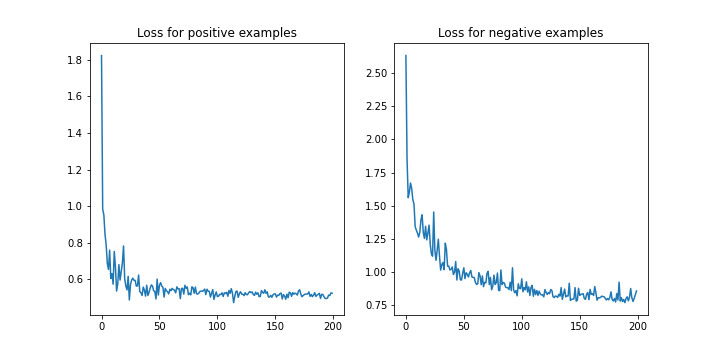

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss for positive examples')
plt.subplot(1, 2, 2)
plt.plot(losses_neg)
plt.title('Loss for negative examples')
plt.show()

# TSNE

In [20]:
from tqdm import tqdm
model.eval()
res_list = None
trg_list = []
for sample_idx in tqdm(range(100)):
    # ----- forward pass -----
    peak1, _, trg = next(test_ds)
    trg_list.append(trg)
    res = model(peak1.unsqueeze(0)).detach().cpu()
    if res_list is None:
        res_list = res
    else:
        res_list = torch.cat((res_list, res), 0)
    # ----- forward pass -----

100%|████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.20it/s]


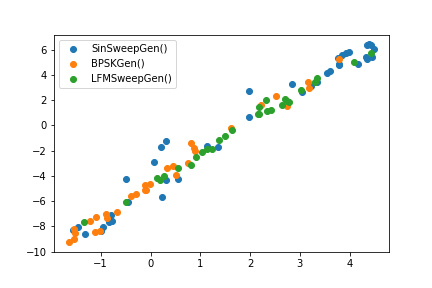

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(res_list.detach())


import numpy as np

plt.figure()

for signal_type in np.unique(trg_list):
    tsne_result_signal_type = tsne_result[trg_list == signal_type]    
    plt.scatter(
        tsne_result_signal_type[:, 0],
        tsne_result_signal_type[:, 1],
        label=test_ds.gen_objs[signal_type]
    )
    
plt.legend()
plt.show()

# EXP

## exp1

peak_width_factor=10

model = FlatNet(
    num_blocks=2,
    num_channels_in=2,
    num_channels_mid=32,
    num_channels_fin=64,
)

losses = []
losses_neg = []
fit(
    model=model,
    train_ds=ds, 
    lr=0.0003,
    num_samples=10000,
    neg_examples=True,
    # device=torch.device('cuda:0'),  # doesnt dp anything anyway
    losses=losses,
    verbose=1,
    log_every=5,
    save_every=1000,
)

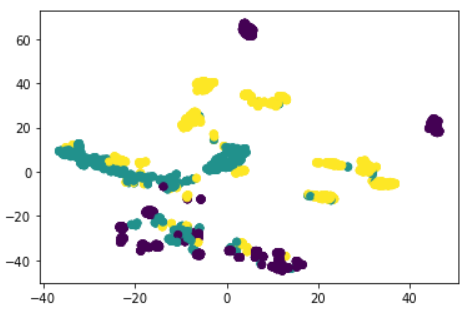

## exp2

peak_width_factor=10

model = FlatNet(
    num_blocks=3,
    num_channels_in=2,
    num_channels_mid=32,
    num_channels_fin=64,
)

losses = []
losses_neg = []
fit(
    model=model,
    train_ds=ds, 
    lr=0.0003,
    num_samples=10000,
    neg_examples=True,
    # device=torch.device('cuda:0'),  # doesnt dp anything anyway
    losses=losses,
    verbose=1,
    log_every=5,
    save_every=1000,
)

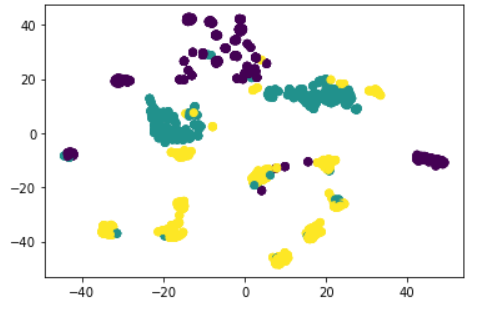

## exp3

peak_width_factor=50

model = FlatNet(
    num_blocks=5,
    num_channels_in=2,
    num_channels_mid=64,
    num_channels_fin=256,
)

calc_num_params(model)

losses = []
losses_neg = []
fit(
    model=model,
    train_ds=ds, 
    pos_weight=5,
    neg_weight=1,
    lr=0.0003,
    num_samples=100,
    device=torch.device('cpu'),
    losses=losses,
    losses_neg=losses_neg,
    verbose=1,
    log_every=5,
    save_every=1000,
)

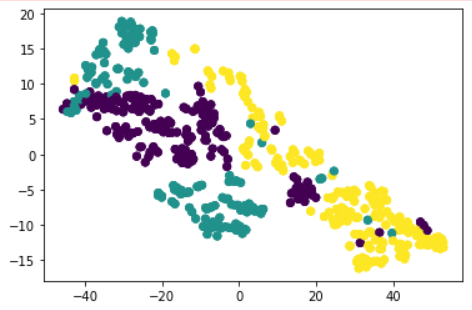

## exp4

peak_width_factor=50

model = FlatNet(
    num_blocks=5,
    num_channels_in=2,
    num_channels_mid=64,
    num_channels_fin=256,
)

calc_num_params(model)

losses = []
losses_neg = []
fit(
    model=model,
    train_ds=ds, 
    pos_weight=1,
    neg_weight=5,
    lr=0.0003,
    num_samples=100,
    device=torch.device('cpu'),
    losses=losses,
    losses_neg=losses_neg,
    verbose=1,
    log_every=5,
    save_every=1000,
)

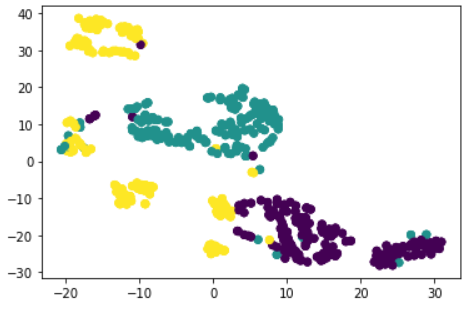

## exp5

running this thing like 10 times while playing with the neg and pos examples weight

peak_width_factor=50

model = FlatNet(
    num_blocks=5,
    num_channels_in=2,
    num_channels_mid=64,
    num_channels_fin=256,
)

calc_num_params(model)

losses = []
losses_neg = []
fit(
    model=model,
    train_ds=ds, 
    pos_weight=1,
    neg_weight=5,
    lr=0.0003,
    num_samples=100,
    device=torch.device('cpu'),
    losses=losses,
    losses_neg=losses_neg,
    verbose=1,
    log_every=5,
    save_every=1000,
)

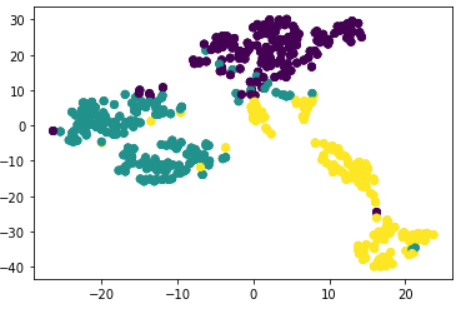